In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D, Bidirectional
from sklearn.model_selection import train_test_split
from keras.initializers import Constant
from keras.optimizers import Adam
from tqdm import tqdm
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
stop=set(stopwords.words('english'))
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv


In [2]:
DATASET_ENCODING = "ISO-8859-1"
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_PATH = "../input/sentiment140/training.1600000.processed.noemoticon.csv"
CURSE_WORDS = ["asshole", "bitch", "crap", "cunt", "damn", "fuck", "hell", "shit", "slut", "nigga", "prick"]

In [3]:
twitter = pd.read_csv(DATASET_PATH, encoding = DATASET_ENCODING, names = DATASET_COLUMNS)
twitter.head(3)
twitter = twitter[["target", "text"]]

In [4]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

In [5]:
hashtags = re.compile(r"^#\S+|\s#\S+")
mentions = re.compile(r"^@\S+|\s@\S+")
urls = re.compile(r"https?://\S+")

def process_text(text):
  text = hashtags.sub(' hashtag', text)
  text = mentions.sub(' entity', text)
  return text.strip().lower()
  
def match_expr(pattern, string):
  return not pattern.search(string) == None

def get_data_wo_urls(dataset):
    link_with_urls = dataset.text.apply(lambda x: match_expr(urls, x))
    return dataset[[not e for e in link_with_urls]]

In [6]:
twitter['text'] = twitter['text'].apply(lambda x : remove_URL(x))
twitter['text'] = twitter['text'].apply(lambda x : remove_html(x))
twitter['text'] = twitter['text'].apply(lambda x : remove_emoji(x))
twitter['text'] = twitter['text'].apply(lambda x : remove_punct(x))

In [8]:
twitter.text = twitter.text.apply(process_text)


In [9]:
curse_words = ' ' + ' | '.join(CURSE_WORDS) + ' '
twitter['text'] = twitter['text'].apply(lambda x : ' ' + x + ' ')
curse_tweets = twitter[twitter["text"].str.contains(curse_words, case=False)]
curse_tweets.shape


(33795, 2)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:ylabel='target'>

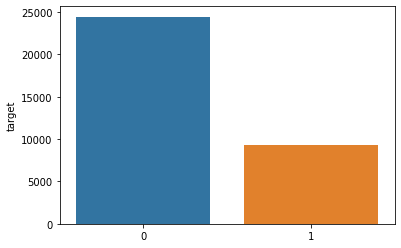

In [10]:
curse_tweets['target'] = curse_tweets['target'].apply(lambda x : 1 if x == 4 else x)
x = curse_tweets.target.value_counts()
sns.barplot(x.index, x)

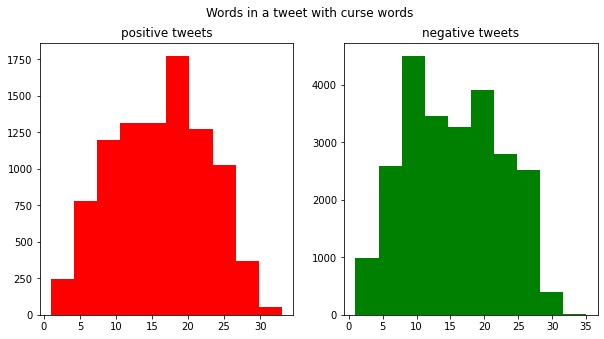

In [11]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=curse_tweets[curse_tweets['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len,color='red')
ax1.set_title('positive tweets')
tweet_len=curse_tweets[curse_tweets['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='green')
ax2.set_title('negative tweets')
fig.suptitle('Words in a tweet with curse words')
plt.show()

In [12]:
!pip install bert-for-tf2


     |████████████████████████████████| 41 kB 104 kB/s eta 0:00:011
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.9-py3-none-any.whl size=30536 sha256=3b5a1908301f0bd137016b9d775276c5618ad4bf1eaa293900accc6789142370
  Stored in directory: /root/.cache/pip/wheels/47/b6/e5/8c76ec779f54bc5c2f1b57d2200bb9c77616da83873e8acb53
  Created wheel for params-flow: filename=params_flow-0.8.2-py3-none-any.whl size=19471 sha256=d3feef43f23e44d64d10518c31566146783c17f7d05d3f5cf3e00cd366935532
  Stored in directory: /root/.cache/pip/wheels/0e/fc/d2/a44fff33af0f233d7def6e7de413006d57c10e10ad736fe8f5
  Created wheel for py-params: filename=py_params-0.10.2-py3-none-any.whl size=7910 sha256=bd5d0b038b40535f1f9ca8c63c9b038371f74e6708d7961aeacde6b1c6db69fa
  Stored in directory: /root/.cache/pip/wheels/e1/11/67/33cc51bbee127cb8fb2ba549cd29109b2f22da43ddf9969716
Successfully built bert-for-tf2 params-flow py-params


In [13]:
import bert
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer

In [14]:
TRAIN_SIZE = 0.7
VAL_SIZE = 0.15
TEST_SIZE = 1 - TRAIN_SIZE - VAL_SIZE

train_val, test = train_test_split(curse_tweets, test_size = TEST_SIZE, random_state = 42)
print("TRAIN size: ", len(train_val))
print("TEST size: ", len(test))


TRAIN size:  28725
TEST size:  5070


In [15]:
!wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip

--2021-06-06 10:11:17--  https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.203.128, 142.250.99.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.203.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407727028 (389M) [application/zip]
Saving to: ‘uncased_L-12_H-768_A-12.zip’

uncased_L-12_H-768_ 100%[===================>] 388.84M  94.1MB/s    in 4.1s    

2021-06-06 10:11:21 (94.1 MB/s) - ‘uncased_L-12_H-768_A-12.zip’ saved [407727028/407727028]



In [16]:
!unzip uncased_L-12_H-768_A-12.zip
os.makedirs("./model", exist_ok=True)
!mv uncased_L-12_H-768_A-12/ ./model

Archive:  uncased_L-12_H-768_A-12.zip
   creating: uncased_L-12_H-768_A-12/
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.meta  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001  
  inflating: uncased_L-12_H-768_A-12/vocab.txt  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.index  
  inflating: uncased_L-12_H-768_A-12/bert_config.json  


In [17]:
bert_model_name="uncased_L-12_H-768_A-12"
bert_ckpt_dir = os.path.join("./model/", bert_model_name)
bert_ckpt_file = os.path.join(bert_ckpt_dir, "bert_model.ckpt")
bert_config_file = os.path.join(bert_ckpt_dir, "bert_config.json")

In [18]:
tokenizer = FullTokenizer(vocab_file = "./model/uncased_L-12_H-768_A-12/vocab.txt")

In [19]:
def create_model(max_seq_len, bert_ckpt_file):

  with tf.io.gfile.GFile(bert_config_file, "r") as reader:
      bc = StockBertConfig.from_json_string(reader.read())
      bert_params = map_stock_config_to_params(bc)
      bert_params.adapter_size = None
      bert = BertModelLayer.from_params(bert_params, name="bert")
        
  input_ids = keras.layers.Input(shape=(max_seq_len, ), dtype='int32', name="input_ids")
  bert_output = bert(input_ids)

  print("bert shape", bert_output.shape)

  cls_out = keras.layers.Lambda(lambda seq: seq[:, 0, :])(bert_output)
  cls_out = keras.layers.Dropout(0.7)(cls_out)
  logits = keras.layers.Dense(units=768, activation="tanh")(cls_out)
  logits = keras.layers.Dropout(0.7)(logits)
  logits = keras.layers.Dense(1, activation="sigmoid")(logits)

  model = keras.Model(inputs=input_ids, outputs=logits)
  model.build(input_shape=(None, max_seq_len))

  load_stock_weights(bert, bert_ckpt_file)
        
  return model
    

In [20]:
train_val.head()

,target,text
687864,0,is listening to combichrist meh need some new...
556892,0,still in bed feeling like crap wishin christi...
177760,0,enithhernandez i apologize for the trollcat c...
914694,1,djspeeddagreat good shit homie hahahahaha tha...
1513859,1,bellezaclasicax quotdime que quieres papiquot...


In [21]:
class SentimentAnalysisData:
  DATA_COLUMN = "text"
  LABEL_COLUMN = "target"

  def __init__(self, train, test, tokenizer: FullTokenizer, classes, max_seq_len=192):
    self.tokenizer = tokenizer
    self.max_seq_len = 0
    self.classes = classes
    
    ((self.train_x, self.train_y), (self.test_x, self.test_y)) = map(self._prepare, [train, test])

    print("max seq_len", self.max_seq_len)
    self.max_seq_len = min(self.max_seq_len, max_seq_len)
    self.train_x, self.test_x = map(self._pad, [self.train_x, self.test_x])

  def _prepare(self, df):
    x, y = [], []
    
    for _, row in tqdm(df.iterrows()):
      text, label = row[SentimentAnalysisData.DATA_COLUMN], row[SentimentAnalysisData.LABEL_COLUMN]
      tokens = self.tokenizer.tokenize(text)
      tokens = ["[CLS]"] + tokens + ["[SEP]"]
      token_ids = self.tokenizer.convert_tokens_to_ids(tokens)
      self.max_seq_len = max(self.max_seq_len, len(token_ids))
      x.append(token_ids)
      y.append(self.classes.index(label))

    return np.array(x), np.array(y)

  def _pad(self, ids):
    x = []
    for input_ids in ids:
      input_ids = input_ids[:min(len(input_ids), self.max_seq_len - 2)]
      input_ids = input_ids + [0] * (self.max_seq_len - len(input_ids))
      x.append(np.array(input_ids))
    return np.array(x)

In [22]:
classes = train_val.target.unique().tolist()

data = SentimentAnalysisData(train_val, test, tokenizer, classes, max_seq_len=40)

28725it [00:15, 1891.10it/s]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
5070it [00:02, 1934.01it/s]


max seq_len 98


In [23]:
data.train_x.shape

(28725, 40)

In [24]:
print(len(data.train_y[data.train_y==0]))
print(len(data.train_y[data.train_y==1]))

20788
7937


In [25]:
print(len(train_val[train_val["target"]==0]))
print(len(train_val[train_val["target"]==1]))
print(len(test[test["target"]==0]))
print(len(test[test["target"]==1]))

20788
7937
3656
1414


In [26]:
data.train_x[0]


array([  101,  2003,  5962,  2000, 22863,  7033, 15061,  2033,  2232,
        2342,  2070,  2047, 24799,  3351,  1998,  2000,  2131,  2035,
        2008, 10231,  2125,  2026, 11943,  5292,  3270,  4687,  2073,
        7648,  2003,   102,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0])

In [27]:
data.train_y[0]

0

In [28]:
data.max_seq_len

40

In [29]:
import tensorflow as tf
import keras

# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)

# instantiate a distribution strategy
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

In [30]:
with tpu_strategy.scope():
    model = create_model(data.max_seq_len, bert_ckpt_file)
    model.summary()
    model.compile(
      optimizer=keras.optimizers.Adam(1e-5),
      loss="binary_crossentropy",
      metrics=["accuracy"]
    )


bert shape (None, 40, 768)
Done loading 196 BERT weights from: ./model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f16a3871b90> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 40)]              0         
_________________________________________________________________
bert (BertModelLayer)        (None, 40, 768)         

In [31]:
history = model.fit(
  x=data.train_x,
  y=data.train_y,
  validation_split=0.2,
  batch_size=32,
  shuffle=True,
  epochs=5,
  verbose=1
)

Epoch 1/5
719/719 [==============================] - 151s 114ms/step - loss: 0.6612 - accuracy: 0.6759 - val_loss: 0.4250 - val_accuracy: 0.8091
Epoch 2/5
719/719 [==============================] - 37s 52ms/step - loss: 0.4553 - accuracy: 0.7978 - val_loss: 0.4446 - val_accuracy: 0.8174
Epoch 3/5
719/719 [==============================] - 38s 52ms/step - loss: 0.3702 - accuracy: 0.8422 - val_loss: 0.4590 - val_accuracy: 0.8181
Epoch 4/5
719/719 [==============================] - 37s 52ms/step - loss: 0.2996 - accuracy: 0.8749 - val_loss: 0.5232 - val_accuracy: 0.8195
Epoch 5/5
719/719 [==============================] - 37s 52ms/step - loss: 0.2174 - accuracy: 0.9153 - val_loss: 0.6134 - val_accuracy: 0.8216


In [32]:
history = model.fit(
  x=data.train_x,
  y=data.train_y,
  validation_split=0.2,
  batch_size=32,
  shuffle=True,
  epochs=2,
  verbose=1
)

Epoch 1/2
719/719 [==============================] - 37s 52ms/step - loss: 0.1525 - accuracy: 0.9434 - val_loss: 0.7459 - val_accuracy: 0.8169
Epoch 2/2
719/719 [==============================] - 38s 53ms/step - loss: 0.1031 - accuracy: 0.9642 - val_loss: 0.8871 - val_accuracy: 0.8155


In [33]:
_, test_acc = model.evaluate(data.test_x, data.test_y)
_, train_acc = model.evaluate(data.train_x, data.train_y)

898/898 [==============================] - 16s 17ms/step - loss: 0.1919 - accuracy: 0.9593
